
**Анализ защищенности систем искусственного интеллекта**

Практическая работа #5

Гребенник Георгий ББМО-01-22

0. Копируем репозиторий проекта и устанавливаем lime:

In [19]:
!git clone https://github.com/marcotcr/lime.git
!pip install lime

fatal: destination path 'lime' already exists and is not an empty directory.


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

In [21]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

mnist_array = mnist.data.to_numpy(dtype=np.uint8)

# make each image color so lime_image works correctly
x_vec = np.stack([gray2rgb(iimg) for iimg in mnist_array.reshape((-1, 28, 28))],0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Text(0.5, 1.0, 'Digit: 5')

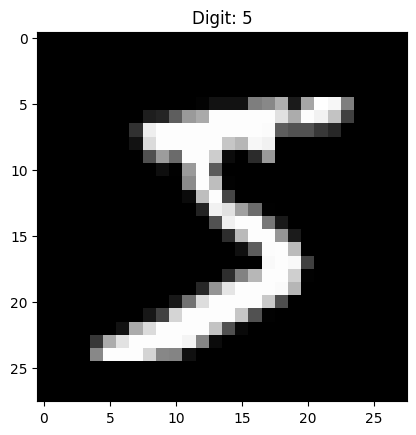

In [22]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(x_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_vec, y_vec,
                                                    train_size=0.55)

In [25]:
simple_rf_pipeline.fit(x_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7fc5dffb1570>),
                ('Flatten Image', <__main__.PipeStep object at 0x7fc5dffb06a0>),
                ('RF', RandomForestClassifier())])

In [26]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


 **In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.**

In [27]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [28]:
%%time
explanation = explainer.explain_instance(x_test[0],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 5.47 s, sys: 87 ms, total: 5.56 s
Wall time: 5.63 s


Text(0.5, 1.0, 'Positive/Negative Regions for 5')

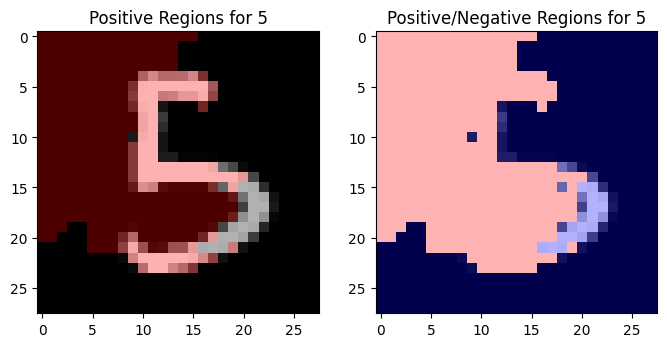

In [29]:
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test.iloc[0]))
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test.iloc[0]))

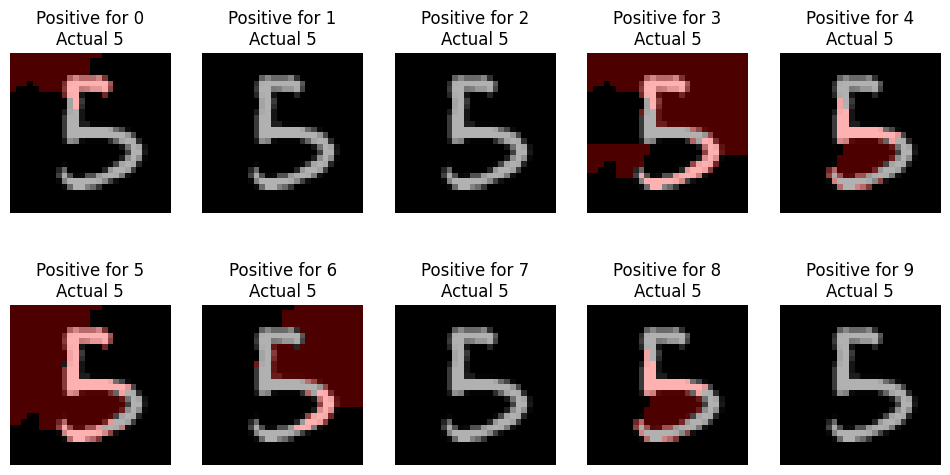

In [30]:
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,x_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.iloc[0]))
    c_ax.axis('off')

In [31]:
pipe_pred_test = simple_rf_pipeline.predict(x_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test.iloc[wrong_idx], pipe_pred_test[wrong_idx]))

Using #29468 where the label was 1 and the pipeline predicted 2


In [32]:
%%time
explanation = explainer.explain_instance(x_test[wrong_idx],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 5.27 s, sys: 99.2 ms, total: 5.37 s
Wall time: 5.43 s


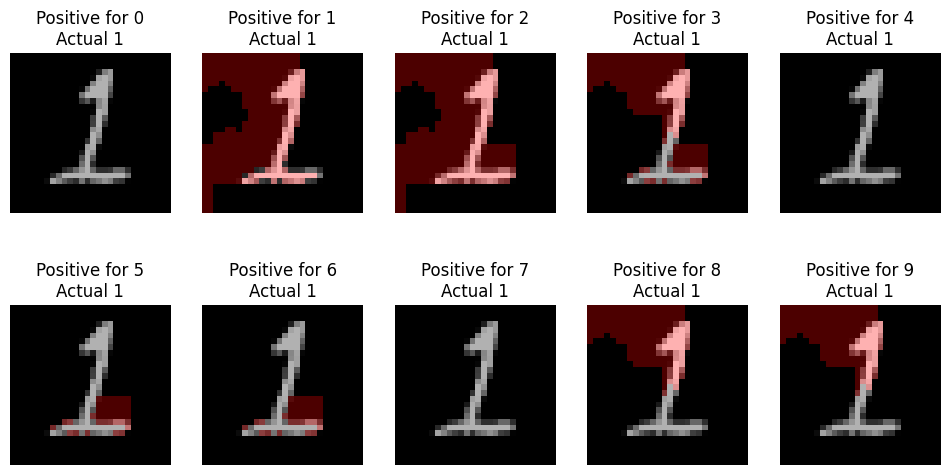

In [33]:
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.iloc[wrong_idx]))
    c_ax.axis('off')